In [6]:
import src
import pandas as pd
import os
import warnings
import numpy as np
warnings.filterwarnings("ignore", category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

from pybedtools.bedtool import BedTool
from pybedtools import cleanup
cleanup()

figure_path = src.figures_path / "genes"
os.makedirs(figure_path, exist_ok=True)

In [7]:
rpkm_columns = ['RPKM_6124', 'RPKM_7165', 'RPKM_bc27_D6_DMSO', 'RPKM_bc28_D6_DMSO']

genexp = pd.read_csv(src.processed_data_path / "gene_expression_MoMaTA_RNAseq.tsv", sep="\t")
genexp = genexp[src.coords + ['strand', 'gene'] + rpkm_columns]
genexp['gene_uid'] = genexp.index

genexp['mean_RPKM'] = genexp[rpkm_columns].mean(1)
genexp['std_RPKM'] = genexp[rpkm_columns].std(1)

genexp['rpkm_class'] = genexp.mean_RPKM.map(src.rpkm_to_class)
genexp['rpkm_class_name'] = genexp.rpkm_class.map(src.rpkm_class_to_name)

genexp.head()

,chr,start,end,strand,gene,RPKM_6124,RPKM_7165,RPKM_bc27_D6_DMSO,RPKM_bc28_D6_DMSO,gene_uid,mean_RPKM,std_RPKM,rpkm_class,rpkm_class_name
0,chr1,11869,14412,+,DDX11L1,0.045055,0.118216,0.010562,0.062163,0,0.058999,0.044934,0,$[0; 1[$
1,chr1,14363,29806,-,WASH7P,4.313933,5.787671,4.241810,2.292184,1,4.158899,1.433926,1,$[1; 10[$
2,chr1,29554,31109,+,MIR1302-10,0.000589,0.000605,0.001523,0.000879,2,0.000899,0.000437,0,$[0; 1[$
3,chr1,34554,36081,-,FAM138A,0.000245,0.000455,0.002638,0.000377,3,0.000929,0.001143,0,$[0; 1[$
4,chr1,52473,54936,+,OR4G4P,0.000289,0.000224,0.000717,0.000532,4,0.000441,0.000227,0,$[0; 1[$


In [8]:
window = 25000
consensus_boundaries = pd.read_csv(src.interim_data_path / "consensus_boundaries" / "consensus_boundaries_w{}.tsv".format(window), sep = "\t")
consensus_boundaries['consensus_boundary_uid'] = np.arange(consensus_boundaries.shape[0], dtype=int)
consensus_boundaries = pd.concat((consensus_boundaries, pd.get_dummies(consensus_boundaries.n_cell_types)), axis=1)
consensus_boundaries.head()

,chr,start,end,boundary_uid,cell_type,n_cell_types,n_boundaries,Ery,MK,Mac0,...,length,covered_genome,consensus_boundary_uid,1,2,3,4,5,6,7
0,chr1,1612500,1612500,Mon_0000_start,Mon,1,1,0,0,0,...,1,3.223947e-10,0,1,0,0,0,0,0,0
1,chr1,1646875,1646875,nB_0000_start,nB,1,1,0,0,0,...,1,3.223947e-10,1,1,0,0,0,0,0,0
2,chr1,1842500,1847500,"nB_0000_end,Ery_0000_start,Mon_0000_end","nB,Mon,Ery",3,3,1,0,0,...,5001,1.612296e-06,2,0,0,1,0,0,0,0
3,chr1,2112500,2112500,"nB_0001_start,Mac0_0000_start","nB,Mac0",2,2,0,0,1,...,1,3.223947e-10,3,0,1,0,0,0,0,0
4,chr1,2342500,2350000,"nB_0001_end,Mac0_0000_end,Ery_0000_end,nB_0002...","nB,Ery,Mac0,nCD8",4,5,1,0,1,...,7501,2.418282e-06,4,0,0,0,1,0,0,0


In [32]:
min_cons=2

genexp_with_bounds = BedTool.from_dataframe(genexp.sort_values(src.coords))\
                            .map(BedTool.from_dataframe(consensus_boundaries), c=list(range(18,25)), o=['sum' for _ in range(18,25)], null=0)\
                            .to_dataframe(names=genexp.columns.tolist()+list(range(1,8)))
genexp_with_bounds['has_boundary'] = (genexp_with_bounds[list(range(min_cons, 8))].sum(1) > 0).map(lambda x: "With boundary" if x else "No boundary")
genexp_with_bounds['None'] = 0
genexp_with_bounds.loc[genexp_with_bounds[list(range(1,8))].sum(1) == 0, 'None'] = 1
genexp_with_bounds.head()

,chr,start,end,strand,gene,RPKM_6124,RPKM_7165,RPKM_bc27_D6_DMSO,RPKM_bc28_D6_DMSO,gene_uid,...,rpkm_class_name,1,2,3,4,5,6,7,has_boundary,None
0,chr1,11869,14412,+,DDX11L1,0.045055,0.118216,0.010562,0.062163,0,...,$[0; 1[$,0,0,0,0,0,0,0,No boundary,1
1,chr1,14363,29806,-,WASH7P,4.313933,5.787671,4.241810,2.292184,1,...,$[1; 10[$,0,0,0,0,0,0,0,No boundary,1
2,chr1,29554,31109,+,MIR1302-10,0.000589,0.000605,0.001523,0.000879,2,...,$[0; 1[$,0,0,0,0,0,0,0,No boundary,1
3,chr1,34554,36081,-,FAM138A,0.000245,0.000455,0.002638,0.000377,3,...,$[0; 1[$,0,0,0,0,0,0,0,No boundary,1
4,chr1,52473,54936,+,OR4G4P,0.000289,0.000224,0.000717,0.000532,4,...,$[0; 1[$,0,0,0,0,0,0,0,No boundary,1


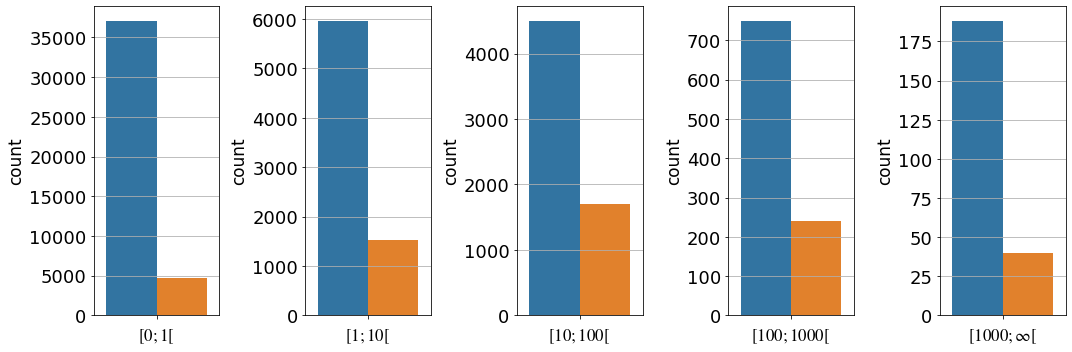

In [33]:
fig, axes = plt.subplots(1, len(src.rpkm_class_to_name.keys()), figsize=(15,5))
for i, g in enumerate(src.rpkm_class_to_name.values()):
    xg = genexp_with_bounds[genexp_with_bounds.rpkm_class_name == g]
    sns.countplot(data=xg, x='rpkm_class_name', hue='has_boundary', ax=axes[i])
    axes[i].legend().set_visible(False)
    axes[i].set_xticklabels([])
    axes[i].set_xlabel(g)
    axes[i].grid(axis="y")

In [34]:
groups = genexp_with_bounds.groupby('rpkm_class_name')[['None'] + list(range(1,8))].sum()

In [37]:
cmap = plt.cm.get_cmap('Reds', 7)
newcolors = cmap(np.linspace(0,1,7))
blue = np.array([1,1,1, 1])
newcolors[0, :] = blue
newcmp = ListedColormap(newcolors)

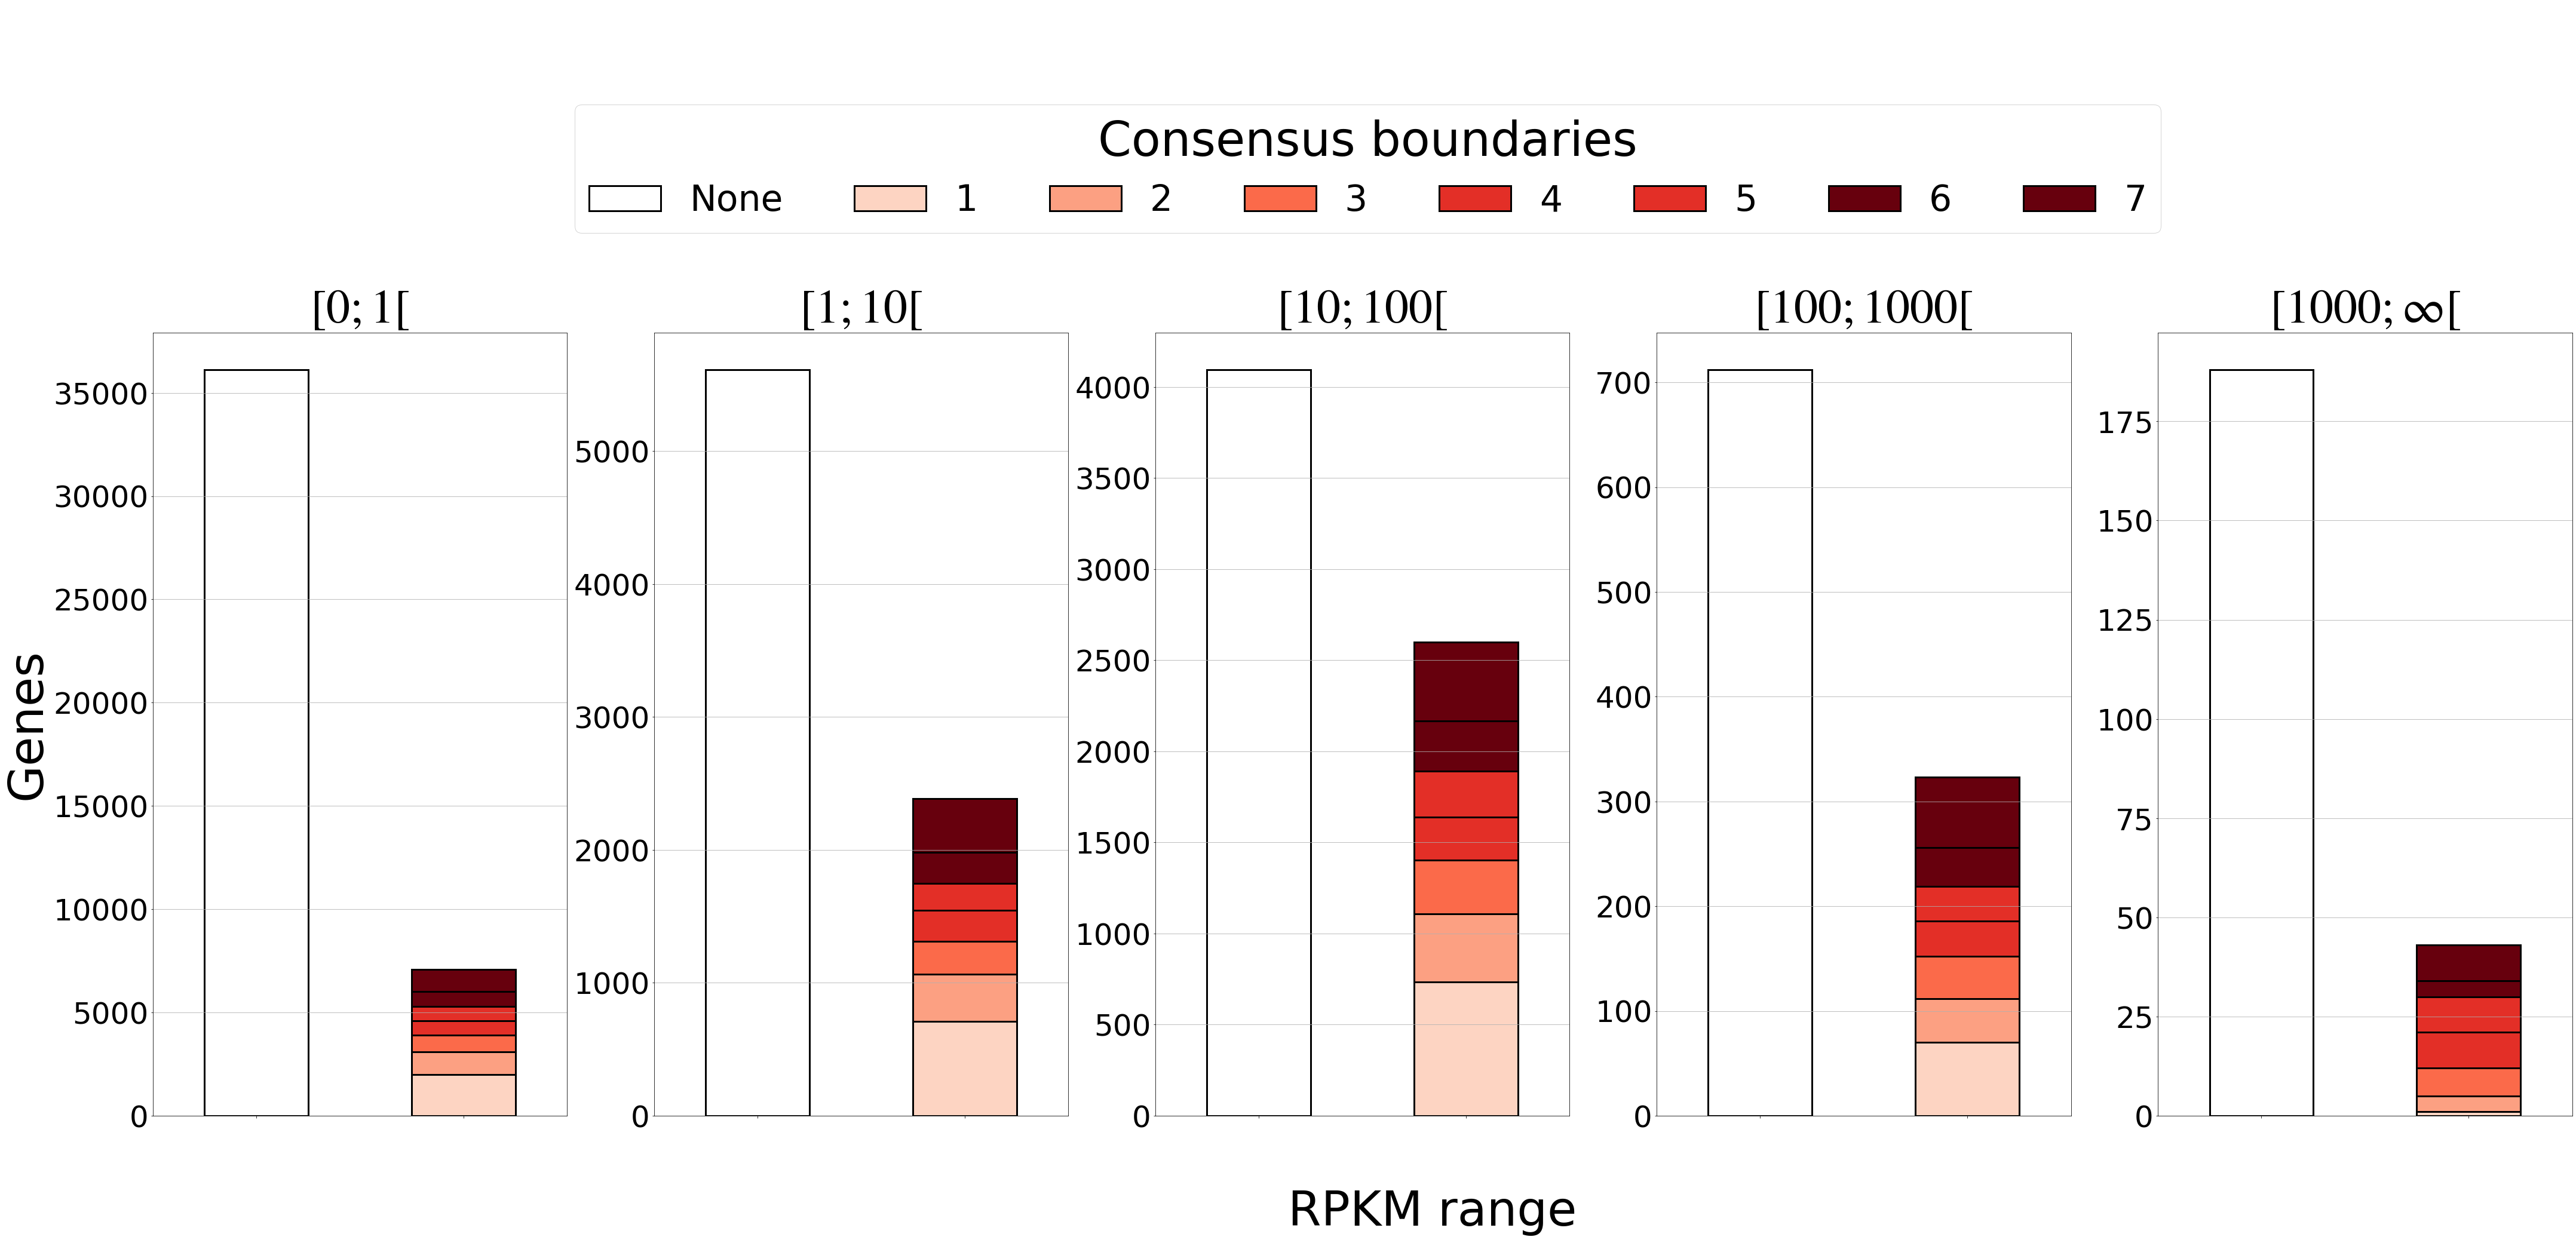

In [39]:
linewidth=3
legendfont = 42
titlefont = 80
labelfont = 40
tickfont = 50


fig, axes = plt.subplots(1, len(src.rpkm_class_to_name.keys()), figsize=(60, 20))
for i, g in enumerate(src.rpkm_class_to_name.values()):
    xg = groups.loc[[g], list(range(1, 8))]
    xg.loc['None', 'None'] = groups.loc[g, 'None']
    xg = xg.fillna(0)
    xg.loc[g, 'None'] = 0
    xg = xg.loc[['None', g], ['None'] + list(range(1, 8))]
    xg.plot.bar(stacked=True, cmap=newcmp, ax=axes[i],edgecolor='black', linewidth=linewidth)
    axes[i].legend().set_visible(False)
    axes[i].set_xticklabels([])
    axes[i].tick_params(axis='y', labelsize=tickfont)
    axes[i].set_xlabel(g)
    axes[i].grid(axis="y")
    axes[i].set_xlabel("")
    axes[i].set_title(g, fontsize=titlefont, fontweight="bold")
axes[0].set_ylabel("Genes", fontsize=80)
handles, labels = axes[i].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=8, 
           bbox_to_anchor=(0.53,1.15), fontsize=60, 
           title='Consensus boundaries', title_fontsize=80)
fig.text(x=0.5, y=-0.1, s="RPKM range", fontsize=80)
plt.show()